In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from datetime import datetime

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[:16]):
        sample = np.array(sample)
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
class batch_norm(object):
    """Code modification of http://stackoverflow.com/a/33950177"""
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum

            self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
            self.name = name

    def __call__(self, x, train=True):
        shape = x.get_shape().as_list()

        if train:
            with tf.variable_scope(self.name) as scope:
                self.beta = tf.get_variable("beta", [shape[-1]],
                                    initializer=tf.constant_initializer(0.))
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                                    initializer=tf.random_normal_initializer(1., 0.02))

                batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
                ema_apply_op = self.ema.apply([batch_mean, batch_var])
                self.ema_mean, self.ema_var = self.ema.average(batch_mean), self.ema.average(batch_var)

                with tf.control_dependencies([ema_apply_op]):
                    mean, var = tf.identity(batch_mean), tf.identity(batch_var)
        else:
            mean, var = self.ema_mean, self.ema_var

        normed = tf.nn.batch_norm_with_global_normalization(
                x, mean, var, self.beta, self.gamma, self.epsilon, scale_after_normalization=True)

        return normed

# standard convolution layer
def conv2d(x, inputFeatures, outputFeatures, name):
    with tf.variable_scope(name):
        w = tf.get_variable("w",[5,5,inputFeatures, outputFeatures], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputFeatures], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(x, w, strides=[1,2,2,1], padding="SAME") + b
        return conv

def conv_transpose(x, outputShape, name):
    with tf.variable_scope(name):
        # h, w, out, in
        w = tf.get_variable("w",[5,5, outputShape[-1], x.get_shape()[-1]], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputShape[-1]], initializer=tf.constant_initializer(0.0))
        convt = tf.nn.conv2d_transpose(x, w, output_shape=outputShape, strides=[1,2,2,1])
        return convt

def deconv2d(input_, output_shape,
             k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
             name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_h, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))

        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        return deconv

# leaky reLu unit
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [inputFeatures, outputFeatures], tf.float32, tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [outputFeatures], initializer=tf.constant_initializer(0.0))
        if with_w:
            return tf.matmul(x, matrix) + bias, matrix, bias
        else:
            return tf.matmul(x, matrix) + bias

In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [6]:
tf.reset_default_graph()

In [ ]:
X = tf.placeholder(tf.float32, shape=[None, 784])

In [44]:
class Model:
    def __init__(self):
        self.X = X =  tf.placeholder(tf.float32, shape=[None, 784])
        self.Y = Y =  tf.placeholder(tf.int32, shape=[None,10])
         
        h1 = tf.layers.dense(X, 100, tf.nn.relu)
        pred = tf.layers.dense(h1, 10, tf.identity)
        
        self.loss = loss =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=pred)
        
        self.optimizer = tf.train.GradientDescentOptimizer(.01).minimize(loss)

In [49]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [48]:
m = Model()

In [88]:
X_u, Y_u = mnist.train.next_batch(mb_size)
Y_u = np.concatenate([Y_u[:,2:], Y_u[:,0:2]], axis=1)
g = sess.run(tf.gradients(m.loss, m.X),
        feed_dict={m.X: X_u, m.Y: Y_u})

In [89]:
g[0]

array([[ 0.01608742, -0.11249542,  0.32827967, ..., -0.16439399,
        -0.11776778,  0.27262926],
       [-0.16961721, -0.27451926, -0.30022508, ..., -0.25251544,
         0.07086565,  0.17685942],
       [-0.27099299,  0.35548234,  0.16940624, ...,  0.04202372,
        -0.05503833,  0.18195716],
       ..., 
       [ 0.07574237,  0.35034406,  0.08843613, ..., -0.09781045,
         0.11654986,  0.20842656],
       [ 0.04612068,  0.18221088,  0.45589426, ..., -0.08960304,
        -0.10044166, -0.2754592 ],
       [-0.0964765 ,  0.35063705, -0.0051636 , ...,  0.12369227,
         0.22868372, -0.23958541]], dtype=float32)

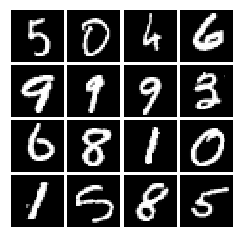

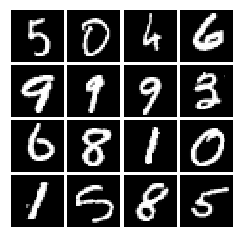

In [93]:
#plot(X_u+g[0]*.1)
plot(X_u)
#plot(g[0])